In [70]:
#import course;course.header()
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

# Retrieve COVID data from ECDC 

In [71]:
covid_url = "https://opendata.ecdc.europa.eu/covid19/casedistribution/json/"
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import json
import urllib
from datetime import datetime

In [72]:
covid_json_unformated = urllib.request.urlopen(covid_url).read().decode("utf-8")
covid_json = json.loads(covid_json_unformated)
cdf = pd.DataFrame(covid_json['records'])

In [73]:
cdf = cdf.rename(columns={
    "countriesAndTerritories": "Country",
    "geoId": "Geo_Id",
    "countryterritoryCode": "Country_code",
    "popData2019": "Population",
    "continentExp": "Continent",
    "Cumulative_number_for_14_days_of_COVID-19_cases_per_100000": "14d_incidence"})
cdf.sample(10)

,dateRep,day,month,year,cases,deaths,Country,Geo_Id,Country_code,Population,Continent,14d_incidence
55918,04/10/2020,04,10,2020,0,0,Timor_Leste,TL,TLS,1293120.0,Asia,0.07733234
38533,26/10/2020,26,10,2020,0,0,Montserrat,MS,MSF,4991.0,America,0
56785,19/08/2020,19,08,2020,0,0,Tunisia,TN,TUN,11694721.0,Africa,5.13907087
8728,12/08/2020,12,08,2020,0,0,Brunei_Darussalam,BN,BRN,433296.0,Asia,0.23078911
50797,14/08/2020,14,08,2020,15,0,Sint_Maarten,SX,SXM,42389.0,America,318.47885065
40330,15/07/2020,15,07,2020,53,0,Netherlands,NL,NLD,17282163.0,Europe,5.05145102
21732,29/05/2020,29,05,2020,3,0,Georgia,GE,GEO,3996762.0,Europe,1.77643803
16022,12/09/2020,12,09,2020,0,0,Djibouti,DJ,DJI,973557.0,Africa,1.12987735
32647,13/11/2020,13,11,2020,1874,12,Lebanon,LB,LBN,6855709.0,Asia,334.3928396
20699,14/01/2020,14,01,2020,0,0,France,FR,FRA,67012883.0,Europe,0


In [74]:

cdf['14d_incidence'] = pd.to_numeric(cdf['14d_incidence'])
cdf.astype({
    "Country":"category",
    "Geo_Id":"category",
    "Country_code":"category",
    "Continent":"category",
})
cdf.dtypes

dateRep           object
day               object
month             object
year              object
cases              int64
deaths             int64
Country           object
Geo_Id            object
Country_code      object
Population       float64
Continent         object
14d_incidence    float64
dtype: object

Rename columns to something more Pythonian. If you think they look already great, then at least rename `notification_rate_per_100000_population_14-days` to `14d-incidence`

Identify which columns have not been casted to an appropriate type during loading!

We did not cover datetime objects in pandas, however they are quite powerful!

Try:

In [75]:
cdf['date_reported_'] = pd.to_datetime(cdf['dateRep'])

Now you can treat the column as a datetime objects using `df[col].dt` , e.g. https://docs.python.org/3/library/datetime.html#datetime.date.year

In [76]:
cdf['date_reported_'].dt.day.head()

0    14
1    13
2    12
3    12
4    12
Name: date_reported_, dtype: int64

In [77]:
day_list = cdf["day"].tolist()
month_list = cdf["month"].tolist()
year_list = cdf["year"].tolist()

datetime_list = []
for i in range(len(day_list)):
    date_str = str(day_list[i]) +"-"+ str(month_list[i]) +"-"+ str(year_list[i])
    date = datetime.strptime(date_str, '%d-%m-%Y')
    #date = datetime.date(day_list[i],month_list[i],year_list[i])
    datetime_list.append(date)


cdf['date_reported'] = pd.to_datetime(datetime_list)

cdf = cdf.drop(columns=["dateRep","day","month","date_reported_"])


In [78]:
oldest = min(cdf['date_reported'].tolist())
cdf.sample(10)
oldest

Timestamp('2019-12-31 00:00:00')

In [79]:
cdf['deltaTime_since_start_of_recording'] = cdf['date_reported']-oldest
cdf.sample(3)

,year,cases,deaths,Country,Geo_Id,Country_code,Population,Continent,14d_incidence,date_reported,deltaTime_since_start_of_recording
42621,2020,459,0,Norway,NO,NOR,5328212.0,Europe,102.248184,2020-12-10,345 days
46597,2020,8262,186,Romania,RO,ROU,19414458.0,Europe,592.532637,2020-11-18,323 days
180,2020,783,13,Afghanistan,AF,AFG,38041757.0,Asia,25.763794,2020-06-17,169 days


Create a new column `deltaTime_since_start_of_recording`

Create histograms for different columns or describe the df. Can you spot the inconsistency in the data? Fix it! :)

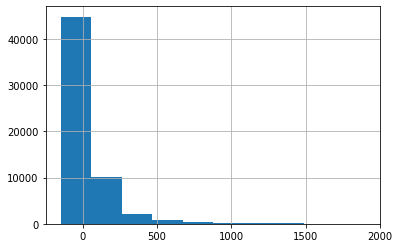

In [80]:
#cdf["deaths"].hist()
#cdf["Population"].hist()
cdf["14d_incidence"].hist()
#cdf["deltaTime_since_start_of_recording"].hist()
mask_14d = cdf["14d_incidence"] < 0
mask_deaths = cdf["deaths"] < 0
cdf = cdf.drop(cdf[mask_14d | mask_deaths].index)
#It seems that negative incidences and death rates exist.

Identify those countries (grouped by continent) which showed the most drastic increase most drastic and decrease of the `14d-incidence` within the different years since recording. Visualize intuitively!

In [81]:
cdf_2020 = cdf[cdf["date_reported"].dt.year == 2020] 
cdf_2021 = cdf[cdf["date_reported"].dt.year == 2021] 

cdf_2020["derivative"] = cdf_2020["14d_incidence"].diff() / cdf_2020["deltaTime_since_start_of_recording"].dt.days.diff()
cdf_2021["derivative"] = cdf_2021["14d_incidence"].diff() / cdf_2021["deltaTime_since_start_of_recording"].dt.days.diff()
grp_cdf_2020 = cdf_2020[['Country','derivative']].groupby(cdf_2020['Continent'])
grp_cdf_2021 = cdf_2021[['Country','derivative']].groupby(cdf_2021["Continent"])
print(grp_cdf_2020.max())
print(grp_cdf_2020.min())
print(grp_cdf_2021.max())
print(grp_cdf_2021.min())


                                              Country  derivative
Continent                                                        
Africa                                       Zimbabwe  129.057760
America                                     Venezuela  338.669556
Asia                                            Yemen  174.224744
Europe                                 United_Kingdom  858.895706
Oceania                             Wallis_and_Futuna  268.900943
Other      Cases_on_an_international_conveyance_Japan         NaN
                                              Country  derivative
Continent                                                        
Africa                                        Algeria -129.057760
America                                      Anguilla -177.935943
Asia                                      Afghanistan -171.621816
Europe                                        Albania -858.895706
Oceania                                     Australia -346.957409
Other     

C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_4192/2597309103.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Which country showed the highest/lowest fluctuation in `14d-incidence` within a year?

In [82]:
cdf_2020["Var"] = cdf_2020["14d_incidence"].var()
cdf_2021["Var"] = cdf_2021["14d_incidence"].var()
cdf_2020.dropna()
cdf_2021.dropna()
print(cdf_2020[['Country','Var']].max())
print(cdf_2020[['Country','Var']].min())
print(cdf_2021[['Country','Var']].max())
print(cdf_2021[['Country','Var']].min())
cdf_2021

C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_4192/2576791923.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Country        Zimbabwe
Var        26360.000421
dtype: object
Country     Afghanistan
Var        26360.000421
dtype: object
Country    NaN
Var        NaN
dtype: object
Country    NaN
Var        NaN
dtype: object


,year,cases,deaths,Country,Geo_Id,Country_code,Population,Continent,14d_incidence,date_reported,deltaTime_since_start_of_recording,derivative,Var


Create a line plot showing the `14-incidence` for all European countries. Use `groupby` operation to generate the data list for the plotly plot. 

In [83]:
cdf_EU = cdf[cdf["Continent"] == "Europe"] 
cdf_EU = cdf_EU.sort_values(by = ["date_reported"])
EU_countries = cdf_EU["Country"].unique()
grp_country = cdf_EU[['Country','14d_incidence',"date_reported"]].groupby(cdf_EU['Country'])

x_list = []
y_list = []
fig = go.Figure()
for country in EU_countries:
    cdf_country_EU = cdf_EU[cdf_EU["Country"] == country] 
    fig.add_trace(go.Scatter(x=cdf_country_EU["date_reported"], y=cdf_country_EU["14d_incidence"], name=country,
                line_shape='spline'))
    y_list.append(cdf_country_EU["14d_incidence"])
    x_list.append(cdf_country_EU["date_reported"])
#fig = px.line(grp_country, x = "date_reported", y = "14d_incidence")

fig.show()
EU_countries


array(['United_Kingdom', 'Spain', 'Norway', 'North_Macedonia',
       'Netherlands', 'Belarus', 'Belgium', 'Estonia', 'Luxembourg',
       'Armenia', 'Ireland', 'San_Marino', 'Azerbaijan', 'Finland',
       'Iceland', 'Greece', 'Czechia', 'Croatia', 'Denmark',
       'Switzerland', 'Monaco', 'Sweden', 'Georgia', 'Germany', 'Austria',
       'France', 'Romania', 'Lithuania', 'Italy', 'Russia', 'Portugal',
       'Andorra', 'Latvia', 'Ukraine', 'Poland', 'Liechtenstein',
       'Slovenia', 'Hungary', 'Faroe_Islands', 'Bosnia_and_Herzegovina',
       'Serbia', 'Slovakia', 'Malta', 'Holy_See', 'Bulgaria', 'Moldova',
       'Albania', 'Cyprus', 'Turkey', 'Kosovo', 'Montenegro', 'Guernsey',
       'Jersey', 'Gibraltar', 'Isle_of_Man'], dtype=object)

Create a smoothed version of the `14d-incidence` by averaging 3 months.

In [84]:

x_list = []
y_list = []
fig = go.Figure()
for country in EU_countries:
    cdf_country_EU = cdf_EU[cdf_EU["Country"] == country]
    cdf_country_EU_averaged = cdf_country_EU.set_index("deltaTime_since_start_of_recording").resample("87D").mean()
    
    delta_list = cdf_country_EU_averaged.index.tolist()
    date_list = []
    for element in delta_list:
        date = cdf_country_EU[cdf_country_EU.deltaTime_since_start_of_recording == element]
        date = date["date_reported"].tolist()[0]
        date_list.append(date)
    cdf_country_EU_averaged["date_reported"] = date_list
    
    fig.add_trace(go.Scatter(x=cdf_country_EU_averaged["date_reported"], y=cdf_country_EU_averaged["14d_incidence"], name=country,
                line_shape='spline'))
    y_list.append(cdf_country_EU_averaged["14d_incidence"])
    x_list.append(cdf_country_EU_averaged["date_reported"])
#fig = px.line(grp_country, x = "date_reported", y = "14d_incidence")

fig.show()

Create a radial plot of death rate / 100000 people (see popData2019), where one year completes a circle, i.e. 360˚. Visualize the recored years for Italy, Germany, Sweden and Greece. Hint you might need to turn the dateTime into `day within the year` (%j) and adjust 365 to 360 degrees. 

In [107]:
country_list = ["Italy","Germany","Sweden","Greece"]
radial_df = cdf_EU[cdf_EU.year == "2020"]
date_reported_list = radial_df["date_reported"].tolist()
day_of_year_list = []
for date in date_reported_list:
    day_of_year_list.append(pd.Period(date, freq = "D").day_of_year)

radial_df["day_of_year"] = day_of_year_list
radial_df["deaths"].dropna()
radial_df["Population"].dropna()
deaths_list = radial_df["deaths"].tolist()
population_list = radial_df["Population"].tolist()
mortality_list = []
for i in range(len(deaths_list)):
    mortality = float(deaths_list[i])/float(population_list[i]) * 100000
    mortality_list.append(mortality)
radial_df["mortality_per_100000"] = mortality_list

for country in country_list:
    country_df = radial_df[radial_df["Country"] == country]
    fig = px.line_polar(country_df, r="mortality_per_100000", theta="day_of_year", line_close=True,
                    template="plotly_dark",)
    fig.show()


C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_4192/2380804637.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_4192/2380804637.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Optional: Find "regular" mortality rates for those countries and visualize it in the plot as well.

,year,cases,deaths,Country,Geo_Id,Country_code,Population,Continent,14d_incidence,date_reported,deltaTime_since_start_of_recording,day_of_year
58727,2019,0,0,United_Kingdom,UK,GBR,66647112.0,Europe,NaN,2019-12-31,0 days,2019-12-31
53071,2019,0,0,Spain,ES,ESP,46937060.0,Europe,NaN,2019-12-31,0 days,2019-12-31
42966,2019,0,0,Norway,NO,NOR,5328212.0,Europe,NaN,2019-12-31,0 days,2019-12-31
42357,2019,0,0,North_Macedonia,MK,MKD,2077132.0,Europe,NaN,2019-12-31,0 days,2019-12-31
40527,2019,0,0,Netherlands,NL,NLD,17282163.0,Europe,NaN,2019-12-31,0 days,2019-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...
34334,2020,517,4,Luxembourg,LU,LUX,613894.0,Europe,1188.967476,2020-12-14,349 days,2020-12-14
8883,2020,497,62,Bulgaria,BG,BGR,7000039.0,Europe,528.039915,2020-12-14,349 days,2020-12-14
46919,2020,28080,488,Russia,RU,RUS,145872260.0,Europe,263.663564,2020-12-14,349 days,2020-12-14
18313,2020,342,1,Estonia,EE,EST,1324820.0,Europe,453.118159,2020-12-14,349 days,2020-12-14
